In [1]:
# Need to load in a comet-stacked image in one of the bands for one of the days.
# Need to rotate image to align tail with x-axis, this can be done manually.
# A perpendicular section can be taken through the optocentre (found using ctk.FindCometCentre).
# A similar section of a nearby field star is also taken (important that this is taken from the rotated image).
# Plot these profiles against distance in arcseconds. They should be normalised.
# If the bare nuculeus is observed, the comet profile will match the star profile in the centre up to a point.
# The wings will be slightly higher, indicating a coma contamination.

In [49]:
import numpy as np
import cometToolkit as ctk
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy

from natsort import natsorted
from glob import glob

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from astroquery.jplhorizons import Horizons

mpl.rcParams.update({'font.size': 14})

In [3]:
reducedDataPaths = natsorted(glob(f"../../Python/DataProducts/ReducedImages/Day13/R/*"))[:-2]

i=0

starsImage = cometImage = ctk.GetImage(reducedDataPaths[i])
#starsImage = ctk.StackImages(rReducedDataPaths)
#cometImage = ctk.GetImage("../DataProducts/StackedImages/Day12/rStacked.fits")

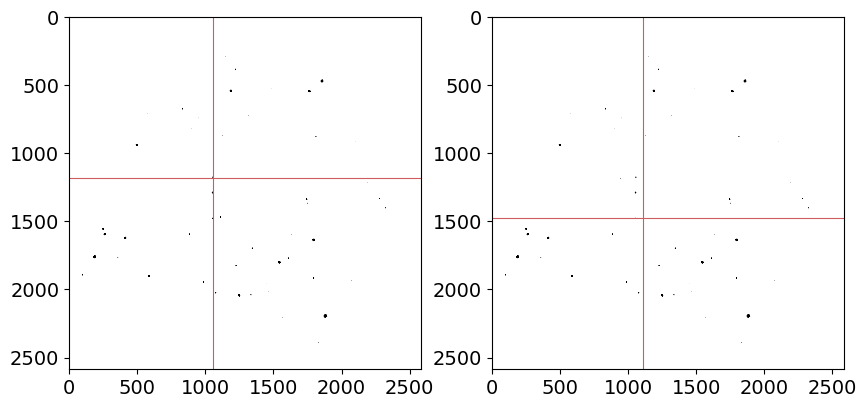

In [4]:
r = -18

cometRotated = scipy.ndimage.rotate(cometImage, r)
starsRotated = scipy.ndimage.rotate(starsImage, r)

sources = ctk.SearchStars(starsRotated)

tol = 50
for source in sources:
    
    # rough positions
    # day12:
    # Star: (800, 1210), Comet: (1200, 1220)

    # day13:
    # Star: (1150, 1500), Comet: (1050, 1150)

    # day14:
    # Star: (400, 850), Comet: (800, 1080)

    # chosing star
    if ((source["xcentroid"] - 1150)**2 < tol**2) and ((source["ycentroid"] - 1500)**2 < tol**2):
        starCentre = (source["xcentroid"], source["ycentroid"])

    # Chosing Comet
    if ((source["xcentroid"] - 1050)**2 < tol**2) and ((source["ycentroid"] - 1150)**2 < tol**2):
        cometCentre = (source["xcentroid"], source["ycentroid"])

#starCentre =(400, 850)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(cometRotated, vmin=500, vmax=1000, cmap="binary")
axes[1].imshow(starsRotated, vmin=500, vmax=1000, cmap="binary")

axes[0].hlines([cometCentre[1]], xmin=0, xmax=len(cometRotated), color="indianred", lw=0.8)
axes[0].vlines([cometCentre[0]], ymin=0, ymax=len(cometRotated), color="indianred", lw=0.8)

axes[1].hlines([starCentre[1]], xmin=0, xmax=len(starsRotated), color="indianred", lw=0.8)
axes[1].vlines([starCentre[0]], ymin=0, ymax=len(starsRotated), color="indianred", lw=0.8)

for ax in axes:
    ax.margins(0)

#axes[1].set_ylim(1400, 1100)
#axes[1].set_xlim(600, 900)

/tmp/ipykernel_1500508/2417827743.py:30: RuntimeWarning: divide by zero encountered in log10
  plt.plot(relativeCometPositions, np.log10(cometProfile), color="indianred", label="Comet Profile")
/tmp/ipykernel_1500508/2417827743.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(relativeStarPositions + [offset]*len(relativeStarPositions), np.log10(starProfile), color="black", label="Star Profile")


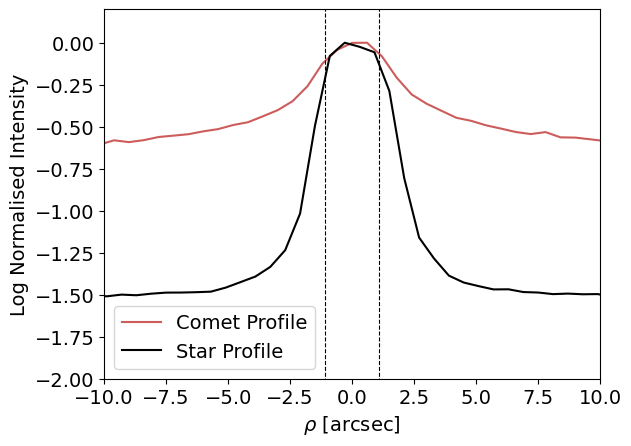

In [25]:
# Get perpendicular profiles

# Comet
cometProfilePosition = round(cometCentre[0])
cometProfile = np.mean(cometRotated[:,cometProfilePosition - 1 : cometProfilePosition + 2], axis=1)

# Star
starProfilePosition = round(starCentre[0])
starProfile = np.mean(starsRotated[:,starProfilePosition - 1 : starProfilePosition + 2], axis=1)


def PixelToArcsec(px):
    return 0.6 * px

def ArcsecToPx(arcsec):
    return arcsec / 0.6

relativeCometPositions = np.array([PixelToArcsec(el - round(cometCentre[1])) for el in range(len(cometProfile))])
relativeStarPositions = np.array([PixelToArcsec(el - round(starCentre[1])) for el in range(len(starProfile))])


# Normalising
centreTolerance = 5

cometProfile = [el/np.max(cometProfile[np.where(relativeCometPositions < centreTolerance)]) for el in cometProfile]
starProfile = [el/np.max(starProfile[np.where(relativeStarPositions < centreTolerance)]) for el in starProfile]

offset = 0.3

plt.plot(relativeCometPositions, np.log10(cometProfile), color="indianred", label="Comet Profile")
plt.plot(relativeStarPositions + [offset]*len(relativeStarPositions), np.log10(starProfile), color="black", label="Star Profile")

nucleusPoint = 1.1
plt.vlines([-nucleusPoint, nucleusPoint], ymin=-3.5, ymax=1, ls="dashed", lw=0.8, color="black")

plt.xlim(-10, 10)
plt.ylim(-2, 0.2)
plt.ylabel("Log Normalised Intensity")
plt.xlabel(r'$\rho$ [arcsec]')
plt.legend()

In [ ]:
# Now we need to determine the coma correction.
# Note, coma correction cannot be calculated for the centre, as we are at the seeing limit
# 
# This will be calculated from the surface brightness. (See O'Ceallaigh 1995)
# Or, the total magnitude with this centre point masked? Maybe??

In [46]:
# Finding the counts in an annulus surrounding the central region

rZeroPoint = 20.32
rZeroPointError = 0.10

size = 3 # arcsec
inner = ArcsecToPx(nucleusPoint)
outer = ArcsecToPx(nucleusPoint+size)
aperture = CircularAnnulus(cometCentre, inner, outer)

phot_table = aperture_photometry(cometImage, aperture)

area = np.pi * (outer**2 - inner**2)
surfaceBrightness = -2.5 * np.log10(phot_table["aperture_sum"][0] / (120 * area)) + rZeroPoint

comaCorrection = surfaceBrightness - 2.5 * np.log10(2 * np.pi * outer**2)

In [51]:
# Find "total magnitude"

aperture = CircularAperture(cometCentre, outer+10)

phot_table = aperture_photometry(cometImage, aperture)

totalMag = -2.5 * np.log10(phot_table["aperture_sum"][0] / 120) + rZeroPoint

nucleusMag = totalMag - 2.5 * np.log10( 1 - 10**(-0.4 * (comaCorrection - totalMag)))


# Variable comet distance
body = Horizons(id=90000670, location="500@3", epochs={"2024-03-14"})
vectors = body.vectors()
earthDistance = vectors["range"][0] # au

body = Horizons(id=90000670, location="500@10", epochs={"2024-03-14"})
vectors = body.vectors()
heliocentricDistance = vectors["range"][0] # au


A = 0.04
beta = 0.035
phase = 9
solarMagnitude = -27.1
radius = (1 / A) * np.sqrt(2.24 * 10**22 * heliocentricDistance**2 * earthDistance * 10**(0.4 * (solarMagnitude - nucleusMag + beta * phase)))

print(radius / 1000) # km

65.04007880342998
